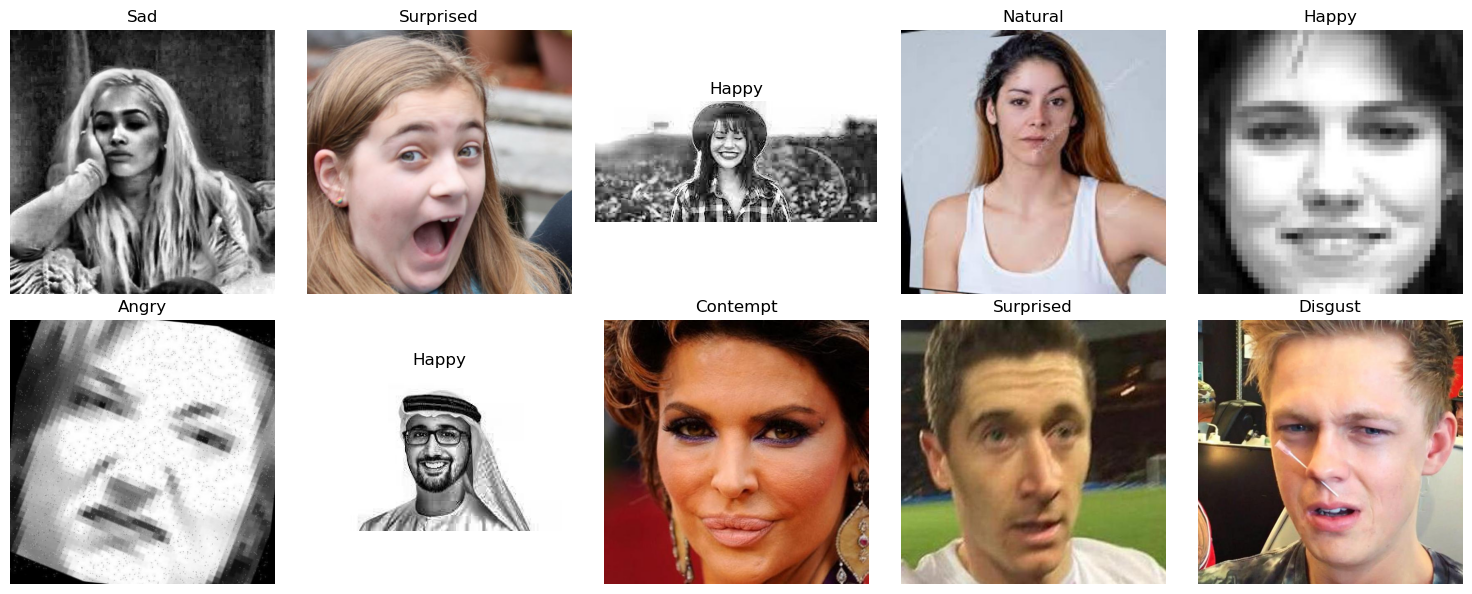

In [1]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

base_dir = './data'

sub_folders = os.listdir(base_dir)

emotion_map = {
    0: 'Angry',
    1: 'Contempt',
    2: 'Disgust',
    3: 'Fear',
    4: 'Happy',
    5: 'Natural',
    6: 'Sad',
    7: 'Sleepy',
    8: 'Surprised'
}

image_labels = []

for folder in sub_folders:
    image_folder = os.path.join(base_dir, folder, 'images')
    label_folder = os.path.join(base_dir, folder, 'labels')

    if os.path.exists(image_folder) and os.path.exists(label_folder):
        # Ottenere la lista dei file immagine
        image_files = [f for f in os.listdir(image_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]

        for image_file in image_files:
            image_path = os.path.join(image_folder, image_file)
            label_file = os.path.splitext(image_file)[0] + '.txt'
            label_path = os.path.join(label_folder, label_file)

            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    label_data = f.readline().strip().split()
                    if label_data:
                        emotion_id = int(label_data[0])
                        if emotion_id in emotion_map:
                            emotion_label = emotion_map[emotion_id]
                            image_labels.append((image_path, emotion_label))

random.shuffle(image_labels)
sample_images = image_labels[:10]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i, (image_path, emotion_label) in enumerate(sample_images):
    try:
        img = Image.open(image_path)
        axes[i].imshow(img)
        axes[i].set_title(emotion_label)
        axes[i].axis('off')
    except FileNotFoundError:
        print(f"File non trovato: {image_path}")
    except Exception as e:
        print(f"Errore durante il caricamento di {image_path}: {e}")

plt.tight_layout()
plt.show()

In [1]:
# import os
# import torch
# from torch.utils.data import Dataset, DataLoader
# from PIL import Image
# from torchvision import transforms, models
# import torch.nn as nn
# import torch.optim as optim
# from tqdm import tqdm
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix
# import random
# import numpy as np 

# # Define the main data directory
# data_dir = './data'

# # Define image size
# image_size = 224

# # Define data transformations
# train_transforms = transforms.Compose([
#     transforms.Resize((image_size, image_size)),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# val_transforms = transforms.Compose([
#     transforms.Resize((image_size, image_size)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# class CustomFacialExpressionDataset(Dataset):
#     def __init__(self, img_dir, labels_dir, transform=None):
#         self.img_dir = img_dir
#         self.labels_dir = labels_dir
#         self.transform = transform
#         self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
#         self.label_files = sorted([f for f in os.listdir(labels_dir) if f.endswith('.txt')])

#         print(f"Found {len(self.img_files)} image files in: {img_dir}")
#         print(f"Found {len(self.label_files)} label files in: {labels_dir}")

#         self.emotion_labels = self._load_emotion_labels()
#         assert len(self.img_files) == len(self.emotion_labels), f"Number of images ({len(self.img_files)}) and loaded labels ({len(self.emotion_labels)}) do not match"

#     def _load_emotion_labels(self):
#         emotion_labels = {}
#         for img_file in self.img_files:
#             img_name_base = os.path.splitext(img_file)[0]
#             label_file = img_name_base + '.txt'
#             label_path = os.path.join(self.labels_dir, label_file)
#             if os.path.exists(label_path):
#                 with open(label_path, 'r') as f:
#                     label_data = f.readline().strip().split()
#                     if label_data:
#                         emotion_id = int(label_data[0])
#                         emotion_labels[img_file] = emotion_id
#             else:
#                 print(f"Warning: Label file not found for image: {img_file}")
#         return emotion_labels

#     def __len__(self):
#         return len(self.img_files)

#     def __getitem__(self, idx):
#         img_name = self.img_files[idx]
#         img_path = os.path.join(self.img_dir, img_name)
#         image = Image.open(img_path).convert('RGB')
#         label = self.emotion_labels[img_name]
#         if self.transform:
#             image = self.transform(image)
#         return image, label

# # Define paths for train and validation images and labels
# train_img_dir = os.path.join(data_dir, 'train', 'images')
# train_labels_dir = os.path.join(data_dir, 'train', 'labels')
# valid_img_dir = os.path.join(data_dir, 'valid', 'images')
# valid_labels_dir = os.path.join(data_dir, 'valid', 'labels')

# # Create Custom Datasets
# print("Creating Custom Datasets...")
# train_dataset = CustomFacialExpressionDataset(train_img_dir, train_labels_dir, transform=train_transforms)
# val_dataset = CustomFacialExpressionDataset(valid_img_dir, valid_labels_dir, transform=val_transforms)
# print("Custom Datasets created.")

# # Define class names
# class_names = [f'Emotion {i}' for i in range(9)]
# num_classes = len(class_names)
# print(f"Number of classes: {num_classes}")
# print(f"Class names: {class_names}")

# # Create DataLoaders
# print("Creating DataLoaders...")
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
# print("DataLoaders created.")

# # Load the pre-trained ResNet-18 model
# print("Loading pre-trained ResNet-18 model...")
# model = models.resnet18(pretrained=True)
# print("Pre-trained ResNet-18 model loaded.")

# # Freeze parameters of all layers except the last fully connected layer
# print("Freezing layers except the last fully connected layer...")
# for param in model.parameters():
#     param.requires_grad = False
# print("Layers frozen.")

# # Modify the last fully connected layer to match the number of classes
# print("Modifying the last fully connected layer...")
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, num_classes)
# print("Last fully connected layer modified.")

# # Move the model to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")
# model = model.to(device)

# # Define the loss function and optimizer
# print("Defining loss function and optimizer...")
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.fc.parameters(), lr=0.001) # Optimize only the parameters of the last layer
# print("Loss function and optimizer defined.")

# # Early stopping parameters
# patience = 3
# best_val_loss = float('inf')
# epochs_no_improve = 0

# # Training loop
# num_epochs = 5
# print("Starting training loop...")
# for epoch in range(num_epochs):
#     print(f"Epoch {epoch+1}/{num_epochs}: Training...")
#     model.train()
#     running_loss = 0.0
#     correct_train = 0
#     total_train = 0
#     train_bar = tqdm(train_loader)
#     for inputs, labels in train_bar:
#         inputs = inputs.to(device)
#         labels = labels.to(device)

#         optimizer.zero_grad()

#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item() * inputs.size(0)

#         _, predicted_train = torch.max(outputs.data, 1)
#         total_train += labels.size(0)
#         correct_train += (predicted_train == labels).sum().item()
#         train_accuracy = 100 * correct_train / total_train

#         train_bar.set_postfix({'loss': f'{loss.item():.4f}', 'accuracy': f'{train_accuracy:.2f}%'})

#     epoch_loss = running_loss / len(train_dataset)
#     epoch_accuracy_train = 100 * correct_train / len(train_dataset)
#     print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy_train:.2f}%')

#     # Validation phase
#     print(f"Epoch {epoch+1}/{num_epochs}: Validation...")
#     model.eval()
#     correct_val = 0
#     total_val = 0
#     all_preds = []
#     all_labels = []
#     val_loss = 0.0
#     val_bar = tqdm(val_loader)
#     with torch.no_grad():
#         for inputs, labels in val_bar:
#             inputs = inputs.to(device)
#             labels = labels.to(device)
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             val_loss += loss.item() * inputs.size(0)
#             _, predicted_val = torch.max(outputs.data, 1)
#             total_val += labels.size(0)
#             correct_val += (predicted_val == labels).sum().item()
#             accuracy_val = 100 * correct_val / total_val
#             val_bar.set_postfix({'accuracy': f'{accuracy_val:.2f}%'})
#             all_preds.extend(predicted_val.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())

#     epoch_accuracy_val = 100 * correct_val / total_val
#     epoch_val_loss = val_loss / len(val_dataset)
#     print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_accuracy_val:.2f}%')

#     # Early stopping check and save best model
#     if epoch_val_loss < best_val_loss:
#         best_val_loss = epoch_val_loss
#         epochs_no_improve = 0
#         torch.save(model.state_dict(), 'best_model.pth')
#         print(f'Validation loss improved. Saving model to best_model.pth')
#     else:
#         epochs_no_improve += 1
#         if epochs_no_improve == patience:
#             print(f'Early stopping triggered after {epoch+1} epochs!')
#             break

# # Load the best model
# model.load_state_dict(torch.load('best_model.pth', map_location=device))
# model.eval()

# # Calculate and visualize the confusion matrix on the validation set
# cm = confusion_matrix(all_labels, all_preds)
# plt.figure(figsize=(12, 10))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix (Validation Set)')
# plt.show()

# print('Finished Training and Saving Best Model')

# # Visualize 10 random images with true and predicted labels
# def visualize_predictions(model, val_dataset, class_names, num_images=10):
#     plt.figure(figsize=(15, 6))
#     indices = random.sample(range(len(val_dataset)), num_images)
#     for i, index in enumerate(indices):
#         image, true_label = val_dataset[index]
#         model.eval()
#         with torch.no_grad():
#             image = image.unsqueeze(0).to(device)
#             output = model(image)
#             _, predicted = torch.max(output, 1)
#             predicted_label = class_names[predicted.item()]
#             true_label_name = class_names[true_label]

#         ax = plt.subplot(2, num_images // 2, i + 1)
#         image_np = image.cpu().squeeze().permute(1, 2, 0).numpy()
#         image_np = (image_np - np.min(image_np)) / (np.max(image_np) - np.min(image_np))
#         ax.imshow(image_np)
#         ax.set_title(f'True: {true_label_name}\nPred: {predicted_label}', fontsize=10)
#         ax.axis('off')
#     plt.tight_layout()
#     plt.show()

# visualize_predictions(model.to(device), val_dataset, class_names, num_images=10)

In [2]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import random
import numpy as np 
from sklearn.utils.class_weight import compute_class_weight



# Define the main data directory
data_dir = './data'

# Define image size
image_size = 224

# Define data transformations
train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


val_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class CustomFacialExpressionDataset(Dataset):
    def __init__(self, img_dir, labels_dir, transform=None):
        self.img_dir = img_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
        self.label_files = sorted([f for f in os.listdir(labels_dir) if f.endswith('.txt')])

        print(f"Found {len(self.img_files)} image files in: {img_dir}")
        print(f"Found {len(self.label_files)} label files in: {labels_dir}")

        self.emotion_labels = self._load_emotion_labels()
        assert len(self.img_files) == len(self.emotion_labels), f"Number of images ({len(self.img_files)}) and loaded labels ({len(self.emotion_labels)}) do not match"

    def _load_emotion_labels(self):
        emotion_labels = {}
        for img_file in self.img_files:
            img_name_base = os.path.splitext(img_file)[0]
            label_file = img_name_base + '.txt'
            label_path = os.path.join(self.labels_dir, label_file)
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    label_data = f.readline().strip().split()
                    if label_data:
                        emotion_id = int(label_data[0])
                        emotion_labels[img_file] = emotion_id
            else:
                print(f"Warning: Label file not found for image: {img_file}")
        return emotion_labels

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        label = self.emotion_labels[img_name]
        if self.transform:
            image = self.transform(image)
        return image, label

# Define paths for train and validation images and labels
train_img_dir = os.path.join(data_dir, 'train', 'images')
train_labels_dir = os.path.join(data_dir, 'train', 'labels')
valid_img_dir = os.path.join(data_dir, 'valid', 'images')
valid_labels_dir = os.path.join(data_dir, 'valid', 'labels')

# Create Custom Datasets
print("Creating Custom Datasets...")
train_dataset = CustomFacialExpressionDataset(train_img_dir, train_labels_dir, transform=train_transforms)
val_dataset = CustomFacialExpressionDataset(valid_img_dir, valid_labels_dir, transform=val_transforms)
print("Custom Datasets created.")


# Define class names
class_names = [f'Emotion {i}' for i in range(9)]
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

# Create DataLoaders
print("Creating DataLoaders...")
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
print("DataLoaders created.")

# Load the pre-trained ResNet-18 model
print("Loading pre-trained ResNet-18 model...")
model = models.resnet18(pretrained=True)
print("Pre-trained ResNet-18 model loaded.")

# Freeze parameters of all layers except the last fully connected layer
print("Freezing layers except the last fully connected layer...")
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

print("Layers frozen.")

# Modify the last fully connected layer to match the number of classes
print("Modifying the last fully connected layer...")
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
print("Last fully connected layer modified.")

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

# Define the loss function and optimizer
print("Defining loss function and optimizer...")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001) # Optimize only the parameters of the last layer
print("Loss function and optimizer defined.")

# Early stopping parameters
patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0

# Training loop
num_epochs = 25
print("Starting training loop...")
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}: Training...")
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    train_bar = tqdm(train_loader)
    for inputs, labels in train_bar:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()
        train_accuracy = 100 * correct_train / total_train

        train_bar.set_postfix({'loss': f'{loss.item():.4f}', 'accuracy': f'{train_accuracy:.2f}%'})

    epoch_loss = running_loss / len(train_dataset)
    epoch_accuracy_train = 100 * correct_train / len(train_dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy_train:.2f}%')

    # Validation phase
    print(f"Epoch {epoch+1}/{num_epochs}: Validation...")
    model.eval()
    correct_val = 0
    total_val = 0
    all_preds = []
    all_labels = []
    val_loss = 0.0
    val_bar = tqdm(val_loader)
    with torch.no_grad():
        for inputs, labels in val_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted_val = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()
            accuracy_val = 100 * correct_val / total_val
            val_bar.set_postfix({'accuracy': f'{accuracy_val:.2f}%'})
            all_preds.extend(predicted_val.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_accuracy_val = 100 * correct_val / total_val
    epoch_val_loss = val_loss / len(val_dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_accuracy_val:.2f}%')

    # Early stopping check and save best model
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'Validation loss improved. Saving model to best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f'Early stopping triggered after {epoch+1} epochs!')
            break

# Load the best model
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.eval()

# Calculate and visualize the confusion matrix on the validation set
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (Validation Set)')
plt.show()

print('Finished Training and Saving Best Model')

# Visualize 10 random images with true and predicted labels
def visualize_predictions(model, val_dataset, class_names, num_images=10):
    plt.figure(figsize=(15, 6))
    indices = random.sample(range(len(val_dataset)), num_images)
    for i, index in enumerate(indices):
        image, true_label = val_dataset[index]
        model.eval()
        with torch.no_grad():
            image = image.unsqueeze(0).to(device)
            output = model(image)
            _, predicted = torch.max(output, 1)
            predicted_label = class_names[predicted.item()]
            true_label_name = class_names[true_label]

        ax = plt.subplot(2, num_images // 2, i + 1)
        image_np = image.cpu().squeeze().permute(1, 2, 0).numpy()
        image_np = (image_np - np.min(image_np)) / (np.max(image_np) - np.min(image_np))
        ax.imshow(image_np)
        ax.set_title(f'True: {true_label_name}\nPred: {predicted_label}', fontsize=10)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_predictions(model.to(device), val_dataset, class_names, num_images=10)

Creating Custom Datasets...
Found 64864 image files in: ./data/train/images
Found 64866 label files in: ./data/train/labels
Found 1720 image files in: ./data/valid/images
Found 1720 label files in: ./data/valid/labels
Custom Datasets created.
Number of classes: 9
Class names: ['Emotion 0', 'Emotion 1', 'Emotion 2', 'Emotion 3', 'Emotion 4', 'Emotion 5', 'Emotion 6', 'Emotion 7', 'Emotion 8']
Creating DataLoaders...
DataLoaders created.
Loading pre-trained ResNet-18 model...


/home/hmuegyi/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hmuegyi/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Pre-trained ResNet-18 model loaded.
Freezing layers except the last fully connected layer...
Layers frozen.
Modifying the last fully connected layer...
Last fully connected layer modified.
Using device: cpu
Defining loss function and optimizer...
Loss function and optimizer defined.
Starting training loop...
Epoch 1/25: Training...


100%|█████████| 2027/2027 [29:39<00:00,  1.14it/s, loss=0.8305, accuracy=61.68%]


Epoch 1/25, Training Loss: 1.0485, Training Accuracy: 61.68%
Epoch 1/25: Validation...


100%|██████████████████████████| 54/54 [00:34<00:00,  1.55it/s, accuracy=70.23%]


Epoch 1/25, Validation Loss: 0.8306, Validation Accuracy: 70.23%
Validation loss improved. Saving model to best_model.pth
Epoch 2/25: Training...


100%|█████████| 2027/2027 [33:12<00:00,  1.02it/s, loss=0.7358, accuracy=71.76%]


Epoch 2/25, Training Loss: 0.7742, Training Accuracy: 71.76%
Epoch 2/25: Validation...


100%|██████████████████████████| 54/54 [00:34<00:00,  1.55it/s, accuracy=72.38%]


Epoch 2/25, Validation Loss: 0.7476, Validation Accuracy: 72.38%
Validation loss improved. Saving model to best_model.pth
Epoch 3/25: Training...


  1%|           | 22/2027 [00:20<31:05,  1.07it/s, loss=0.5938, accuracy=73.58%]


KeyboardInterrupt: 

In [20]:
# Visualize 10 random images with true and predicted labels
def visualize_predictions(model, val_dataset, class_names, num_images=10):
    plt.figure(figsize=(15, 6))
    indices = random.sample(range(len(val_dataset)), num_images)
    for i, index in enumerate(indices):
        image, true_label_index = val_dataset[index]
        model.eval()
        with torch.no_grad():
            image = image.unsqueeze(0).to(device)
            output = model(image)
            _, predicted_index = torch.max(output, 1)
            predicted_label = class_names[predicted_index.item()]
            true_label = class_names[true_label_index]

        ax = plt.subplot(2, num_images // 2, i + 1)
        image_np = image.cpu().squeeze().permute(1, 2, 0).numpy()
        image_np = (image_np - np.min(image_np)) / (np.max(image_np) - np.min(image_np))
        ax.imshow(image_np)
        ax.set_title(f'True: {true_label}\nPred: {predicted_label}', fontsize=10)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [22]:
# import os
# import torch
# from torch.utils.data import Dataset, DataLoader
# from PIL import Image
# from torchvision import transforms, models
# import torch.nn as nn
# import torch.optim as optim
# from tqdm import tqdm
# import matplotlib.pyplot as plt
# import numpy as np
# import cv2  # OpenCV for heatmap overlay
# import random

# # Define the main data directory
# data_dir = './data'

# # Define image size
# image_size = 224

# # Define data transformations (without normalization for CAM visualization)
# transform_cam = transforms.Compose([
#     transforms.Resize((image_size, image_size)),
#     transforms.ToTensor(),
# ])

# # Define class names
# class_names = [
#     'Angry',
#     'Contempt',
#     'Disgust',
#     'Fear',
#     'Happy',
#     'Natural',
#     'Sad',
#     'Sleepy',
#     'Surprised'
# ]
# num_classes = len(class_names)
# print(f"Number of classes: {num_classes}")
# print(f"Class names: {class_names}")

# class CustomFacialExpressionDataset(Dataset):
#     def __init__(self, img_dir, labels_dir, transform=None):
#         self.img_dir = img_dir
#         self.labels_dir = labels_dir
#         self.transform = transform
#         self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
#         self.label_files = sorted([f for f in os.listdir(labels_dir) if f.endswith('.txt')])
#         self.emotion_labels = self._load_emotion_labels()

#     def _load_emotion_labels(self):
#         emotion_labels = {}
#         for img_file in self.img_files:
#             img_name_base = os.path.splitext(img_file)[0]
#             label_file = img_name_base + '.txt'
#             label_path = os.path.join(self.labels_dir, label_file)
#             if os.path.exists(label_path):
#                 with open(label_path, 'r') as f:
#                     label_data = f.readline().strip().split()
#                     if label_data:
#                         emotion_id = int(label_data[0])
#                         emotion_labels[img_file] = emotion_id
#         return emotion_labels

#     def __len__(self):
#         return len(self.img_files)

#     def __getitem__(self, idx):
#         img_name = self.img_files[idx]
#         img_path = os.path.join(self.img_dir, img_name)
#         image = Image.open(img_path).convert('RGB')
#         label = self.emotion_labels[img_name]
#         if self.transform:
#             image = self.transform(image)
#         return image, label

# # Define paths for validation images and labels
# valid_img_dir = os.path.join(data_dir, 'valid', 'images')
# valid_labels_dir = os.path.join(data_dir, 'valid', 'labels')

# # Create Validation Dataset for CAM
# val_dataset_cam = CustomFacialExpressionDataset(valid_img_dir, valid_labels_dir, transform=transform_cam)
# val_loader_cam = DataLoader(val_dataset_cam, batch_size=4, shuffle=True) # Reduced batch size for visualization

# # Load the best trained ResNet-18 model
# model = models.resnet18(pretrained=False)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, num_classes)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.load_state_dict(torch.load('best_model.pth', map_location=device))
# model.eval().to(device)

# # Function to get the feature maps of the last convolutional layer
# last_conv_layer_name = 'layer4'
# feature_maps = {}
# def get_feature_maps(name):
#     def hook(module, input, output):
#         feature_maps[name] = output.detach()
#     return hook

# # Register the hook to get the feature maps of the last convolutional layer
# layer = model._modules.get(last_conv_layer_name)
# handle = layer.register_forward_hook(get_feature_maps(last_conv_layer_name))

# def generate_cam(model, input_tensor, target_class):
#     output = model(input_tensor)
#     _, predicted_class = torch.max(output, 1)

#     # Get the feature maps of the last convolutional layer
#     conv_output = feature_maps[last_conv_layer_name]

#     # Get the weights of the fully connected layer for the target class
#     weights = model.fc.weight[target_class].detach()

#     # Generate the CAM
#     cam = torch.mul(conv_output, weights.unsqueeze(0).unsqueeze(2).unsqueeze(3)).sum(dim=1, keepdim=True)
#     cam = torch.relu(cam) # ReLU to consider only positive activations
#     cam = cam - torch.min(cam)
#     cam = cam / (torch.max(cam) + 1e-7) # Normalize between 0 and 1

#     return cam.squeeze().cpu().numpy(), predicted_class.item()

# def show_cam_on_image(img_tensor, heatmap):
#     img = img_tensor.permute(1, 2, 0).cpu().numpy()
#     img = (img - np.min(img)) / (np.max(img) - np.min(img)) # Normalize original image

#     heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
#     heatmap = np.uint8(255 * heatmap)
#     heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

#     # Explicitly convert heatmap to the same data type as img
#     heatmap_float = heatmap.astype(np.float32) / 255.0
#     cam = cv2.addWeighted(img.astype(np.float32), 0.6, heatmap_float, 0.4, 0)
#     return cam

# # Visualize the CAMs for some example images
# num_images_to_show = 4
# dataiter_cam = iter(val_loader_cam)
# images, true_labels = next(dataiter_cam)
# images = images.to(device)

# fig, axes = plt.subplots(num_images_to_show, 2, figsize=(10, 5 * num_images_to_show))

# for i in range(num_images_to_show):
#     input_tensor = images[i].unsqueeze(0)
#     true_label = true_labels[i].item()

#     # Generate CAM for the true class
#     cam_true, _ = generate_cam(model, input_tensor, true_label)
#     cam_image_true = show_cam_on_image(images[i].cpu(), cam_true)

#     # Generate CAM for the predicted class
#     with torch.no_grad():
#         output = model(input_tensor)
#         _, predicted_class = torch.max(output, 1)
#         cam_pred, _ = generate_cam(model, input_tensor, predicted_class.item())
#         cam_image_pred = show_cam_on_image(images[i].cpu(), cam_pred)

#     axes[i, 0].imshow(cam_image_true)
#     axes[i, 0].set_title(f'True: {class_names[true_label]}')
#     axes[i, 0].axis('off')

#     axes[i, 1].imshow(cam_image_pred)
#     axes[i, 1].set_title(f'Predicted: {class_names[predicted_class.item()]}')
#     axes[i, 1].axis('off')

# plt.tight_layout()
# plt.show()

# # Remove the hook
# handle.remove()

In [18]:
import cv2
import torch
from torchvision import transforms, models
import torch.nn as nn
from PIL import Image
import numpy as np

# Define emotion class names
class_names = [
    'Angry',
    'Contempt',
    'Disgust',
    'Fear',
    'Happy',
    'Natural',
    'Sad',
    'Sleepy',
    'Surprised'
]

# Define image size and transform
image_size = 224
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

# Load the trained model
num_classes = len(class_names)
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.eval().to(device)

# Start video capture
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to PIL image
    img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    input_tensor = transform(img).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted_class = torch.max(output, 1)
        label = class_names[predicted_class.item()]

    # Show predicted label on video
    cv2.putText(frame, f'Emotion: {label}', (20, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)

    # Show the frame
    cv2.imshow('Emotion Detection', frame)

    # Break on 'q' key
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()
